# Тестовое задание в AVSoft
Выполнил: Ларькин Владимир <vladimir@larkin.one>

План работы:
1. подготовить датасет к использованию для обучения модели,
2. выбрать модель ML,
3. обучить модель,
4. измерить качество модели,
5. попробовать улучшить качество модели.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"
%matplotlib inline

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.size"] = 12

Зафиксируем сид для воспроизводимости

In [2]:
SEED = 42

In [3]:
import random

random.seed(SEED)
np.random.seed(SEED)

## Загрузка и обработка данных

In [4]:
df = pd.read_csv("АВСОФТ_тест_ML_приложение.csv")
df

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1


Посмотрим, какие бывают названия репозиториев:

In [5]:
df["repository_name"].unique()

array(['mlm', 'standard', 'agent', 'conductor', 'dockers', 'sensor'],
      dtype=object)

И имена авторов:

In [6]:
df["commit_author"].unique()

array(['Victor', 'Peggy', 'Wendy', 'Trudy', 'Mallory', 'Eve', 'Dabe',
       'Carol', 'Bob', 'Alice'], dtype=object)

Предположительно, поле с хешем бесполезно для нас, так как уникально для каждого коммита. Убедимся в этом:

In [7]:
df["commit_hash"].unique().shape

(319,)

Гипотеза подтвердилась — количество уникальных значений в этом столбце равно количеству строк в таблице. С чистой совестью удаляем столбец:

In [8]:
df.drop("commit_hash", axis=1, inplace=True)

Посмотрим, нет ли пустых значений в таблице:

In [9]:
df.isna().sum()

repository_name    0
commit_date        0
commit_author      0
commit_message     0
bugs               0
dtype: int64

(нет)

Посмотрим типы:

In [10]:
df.dtypes

repository_name    object
commit_date        object
commit_author      object
commit_message     object
bugs                int64
dtype: object

Видим, что тип поля даты не DateTime, исправим это:

In [11]:
df["commit_date"] = pd.to_datetime(df["commit_date"])
df.head()

,repository_name,commit_date,commit_author,commit_message,bugs
0,mlm,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7


Теперь вытащим из даты информацию отдельно о годе, месяце, дне, часе, минуте, секунде:

In [12]:
df["year"] = df["commit_date"].apply(lambda t: t.year)
df["year"].unique()

array([2020])

Оказывается, все коммиты в датасете сделаны в 2020 году. Удалим столбец с годом:

In [13]:
df.drop("year", axis=1, inplace=True)

In [14]:
df["month"] = df["commit_date"].apply(lambda t: t.month)
df["month"].unique()

array([6, 3, 5, 4])

In [15]:
df["day"] = df["commit_date"].apply(lambda t: t.day)
df["day"].unique()

array([12, 11, 10,  9,  5,  4,  3,  2, 22, 21,  8, 18, 15, 14, 13,  7,  6,
        1, 30, 27, 20, 19, 29, 24, 17, 23, 16, 25, 28])

Ещё добавим номер дня недели и дополнительно проставим флаг, был ли это выходной:

In [16]:
df["day_of_week"] = df["commit_date"].apply(lambda t: t.day_of_week)
df["day_of_week"].unique()

array([4, 3, 2, 1, 6, 5, 0])

In [17]:
df["is_weekend"] = (df["day_of_week"].isin([5, 6])).astype(int)
df["is_weekend"].unique()

array([0, 1])

In [18]:
df["hour"] = df["commit_date"].apply(lambda t: t.hour)
df["hour"].unique()

array([14, 11, 15, 10,  9, 13, 12,  8, 17, 16,  6, 23,  7, 18, 21, 22, 20,
       19])

In [19]:
df["minute"] = df["commit_date"].apply(lambda t: t.minute)
df["minute"].unique()

array([26, 53, 19, 42, 25, 12, 34, 22, 54, 32, 45,  5, 51, 15, 17, 37,  2,
       43, 27, 41, 13,  0, 56, 16, 14, 33, 46, 23, 18, 38,  6,  4, 47, 49,
        8, 35,  7, 50, 59, 28, 30, 36, 57, 40, 20, 52, 44, 24,  1, 31, 48,
        9, 11, 21, 10,  3, 55, 39, 58])

In [20]:
df["second"] = df["commit_date"].apply(lambda t: t.second)
df["second"].unique()

array([12, 10,  3, 29, 19, 37, 22,  4, 21, 14,  9, 18, 30, 54, 46, 15, 52,
       17, 51, 24,  5,  8, 33, 55,  2, 32, 45, 38, 35, 16, 34, 11, 59, 39,
       28, 58, 53, 57, 31, 43, 27, 23, 47, 13, 25,  6, 26,  0, 36, 56,  1,
       41, 44, 40, 20, 48,  7, 42, 50])

In [21]:
df.head()

,repository_name,commit_date,commit_author,commit_message,bugs,month,day,day_of_week,is_weekend,hour,minute,second
0,mlm,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,6,12,4,0,14,26,12
1,mlm,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,6,12,4,0,11,53,10
2,mlm,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,6,11,3,0,15,19,3
3,mlm,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,6,11,3,0,10,42,29
4,mlm,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,6,11,3,0,9,25,19


Убедимся, что на этот раз все типы правильные:

In [22]:
df.dtypes

repository_name            object
commit_date        datetime64[ns]
commit_author              object
commit_message             object
bugs                        int64
month                       int64
day                         int64
day_of_week                 int64
is_weekend                  int64
hour                        int64
minute                      int64
second                      int64
dtype: object

Построим матрицу корреляций и относительные распределения:

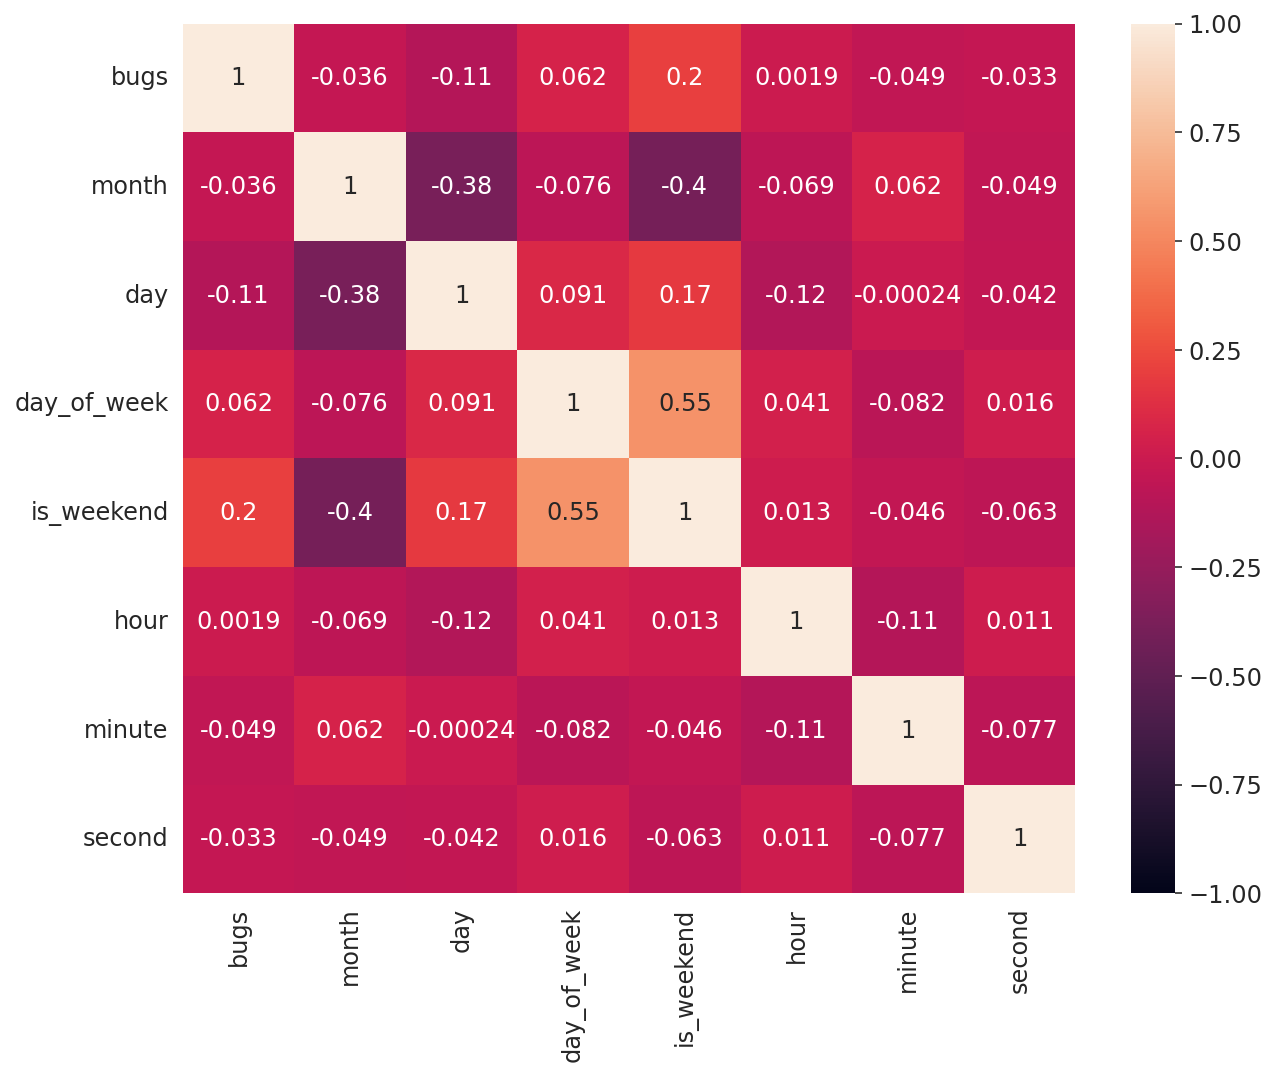

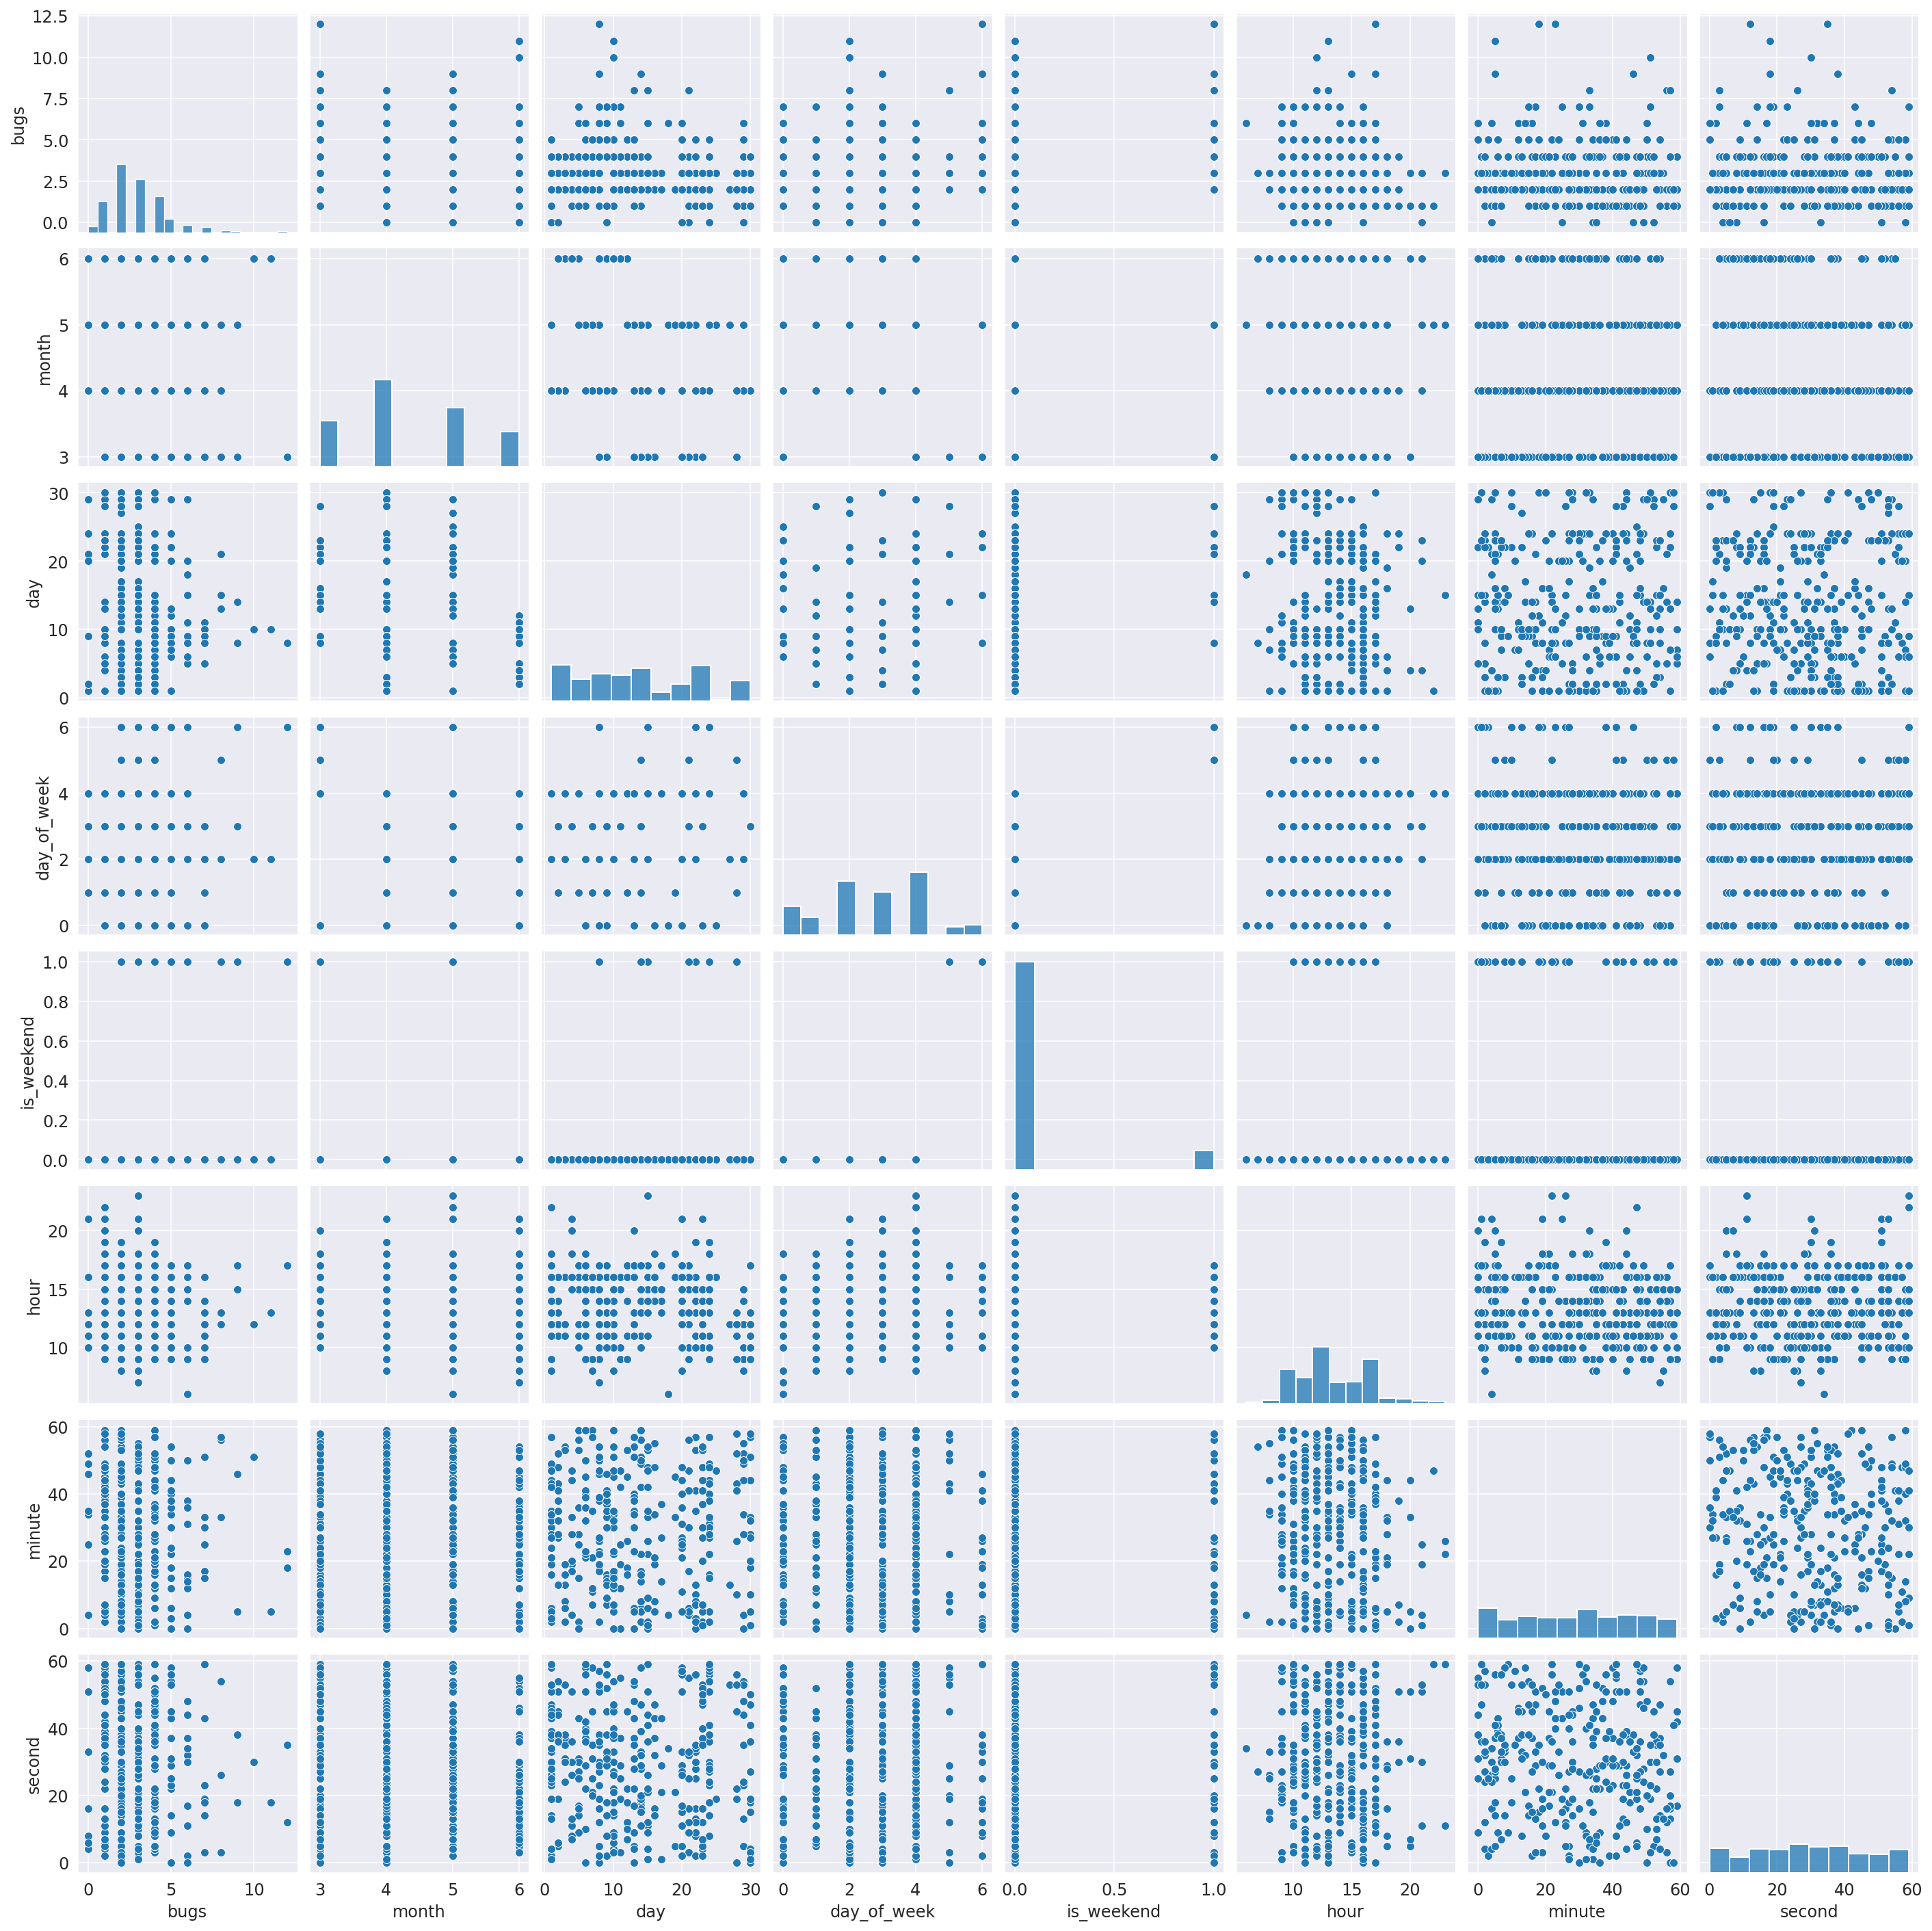

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, vmax=1, vmin=-1)
sns.pairplot(df);

Выпишем в отдельные списки названия столбцов с категориальными и числовыми признаками:

In [24]:
df.columns

Index(['repository_name', 'commit_date', 'commit_author', 'commit_message',
       'bugs', 'month', 'day', 'day_of_week', 'is_weekend', 'hour', 'minute',
       'second'],
      dtype='object')

In [25]:
cat_columns = ["repository_name", "commit_author"]
num_columns = ["month", "day", "day_of_week", "is_weekend", "hour", "minute", "second"]

Сделаем one-hot кодирование категориальных признаков:

In [26]:
one_hot = pd.get_dummies(df[cat_columns])
one_hot.head()

,repository_name_agent,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,commit_author_Alice,commit_author_Bob,commit_author_Carol,commit_author_Dabe,commit_author_Eve,commit_author_Mallory,commit_author_Peggy,commit_author_Trudy,commit_author_Victor,commit_author_Wendy
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [27]:
one_hot.shape, df[num_columns].shape

((319, 16), (319, 7))

Соединим в один датафрейм закодированные категориальные и числовые признаки и создадим матрицу $X$ и вектор $y$ (столбец `bugs`). Столбец `commit_message` пока не будем использовать, посмотрим сначала, что получится без него.

In [28]:
X = pd.concat([one_hot, df[num_columns]], axis=1)
y = df["bugs"]
X.shape, y.shape

((319, 23), (319,))

## Обучение на одних категориальных и числовых признаках

Разделим на обучающую и тестовую выборки:

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test, msg_train, msg_test = train_test_split(
    X, y, df["commit_message"], test_size=0.2, shuffle=True, random_state=SEED
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, msg_train.shape, msg_test.shape

((255, 23), (64, 23), (255,), (64,), (255,), (64,))

Из моделей попробуем линейную регрессию как самую простую, случайный лес и градиентный бустинг.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

Для удобства напишем функции для вывода метрик и обучения модели. Из метрик берём MSE — средний квадрат ошибки, так как эта функция потерь минимизируется при обучении, и $R^2$ — коэффициент детерминации, классический для задач регрессии. Чем ближе к единице $R^2$, тем лучше.

In [32]:
from sklearn.metrics import r2_score, mean_squared_error

def print_metrics(y_true, y_pred):
    print(f"R^2 = {r2_score(y_true=y_true, y_pred=y_pred)}")
    print(f"MSE = {mean_squared_error(y_true=y_true, y_pred=y_pred)}")
    
def fit_score_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print_metrics(y_test, pred)

Обучим модели:

In [33]:
fit_score_model(LinearRegression(), X_train, y_train, X_test, y_test)

R^2 = -0.08813426291370319
MSE = 2.7158194750407194


In [34]:
fit_score_model(RandomForestRegressor(random_state=SEED), X_train, y_train, X_test, y_test)

R^2 = -0.014725853467670857
MSE = 2.532603125


In [35]:
fit_score_model(CatBoostRegressor(random_state=SEED, silent=True), X_train, y_train, X_test, y_test)

R^2 = -0.14379277116850764
MSE = 2.8547347411268684


Все модели показали одинаково плохой результат, а отрицательный коэффициент детерминации говорит о том, что модели вообще не объясняют существующую зависимость.

## Обучение с текстовыми данными

Добавим в данные столбец `commit_message` путём векторизации методом TF-IDF:

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorizer = TfidfVectorizer()
vec_train = vectorizer.fit_transform(msg_train)
vec_test = vectorizer.transform(msg_test)

vec_train.shape, vec_test.shape

((255, 599), (64, 599))

In [38]:
X_train = np.hstack([X_train.to_numpy(), vec_train.toarray()])
X_test = np.hstack([X_test.to_numpy(), vec_test.toarray()])

X_train.shape, X_test.shape

((255, 622), (64, 622))

Обучим модели на новых данных:

In [39]:
fit_score_model(LinearRegression(), X_train, y_train, X_test, y_test)

R^2 = -0.5592130667764765
MSE = 3.891561323646465


In [40]:
forest = RandomForestRegressor(random_state=SEED)
fit_score_model(forest, X_train, y_train, X_test, y_test)

R^2 = 0.2598349603834491
MSE = 1.847340625


In [41]:
boost = CatBoostRegressor(random_state=SEED, silent=True)
fit_score_model(boost, X_train, y_train, X_test, y_test)

R^2 = 0.2485234624359598
MSE = 1.8755724227336872


Линейная регрессия снова показывает плохой результат, а вот $R^2$ случайного леса и бустинга стал очень похожим и вырос до 25%.

## Анализ важности отдельных признаков

Проанализируем степень влияния различных признаков на качество нашей регрессии.

Для оценки будем использовать кросс-валидацию, для чего напишем специальную функцию:

In [42]:
from sklearn.model_selection import KFold

def score_model_cv(model, X, y, n):
    scores = []
    importances = {}
    kfold = KFold(n_splits=n, random_state=SEED, shuffle=True)
    
    for train_index, test_index in kfold.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        vectorizer = TfidfVectorizer()    
        vec_train = vectorizer.fit_transform(X_train["commit_message"]).toarray()
        vec_test = vectorizer.transform(X_test["commit_message"]).toarray()
        
        X_train = np.hstack([X_train.drop("commit_message", axis=1).to_numpy(), vec_train])
        X_test = np.hstack([X_test.drop("commit_message", axis=1).to_numpy(), vec_test])
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores.append(r2_score(y_test, pred))
        
        col_names = list(X.columns[:(len(num_columns) + one_hot.shape[1])]) + list(vectorizer.get_feature_names())
        
        for key, value in zip(col_names, model.feature_importances_):
            if key not in importances.keys():
                importances[key] = [value]
            else:
                importances[key].append(value)
    
    return scores, importances

In [43]:
X = pd.concat([one_hot, df[num_columns], df["commit_message"]], axis=1)
y = df["bugs"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((239, 24), (80, 24), (239,), (80,))

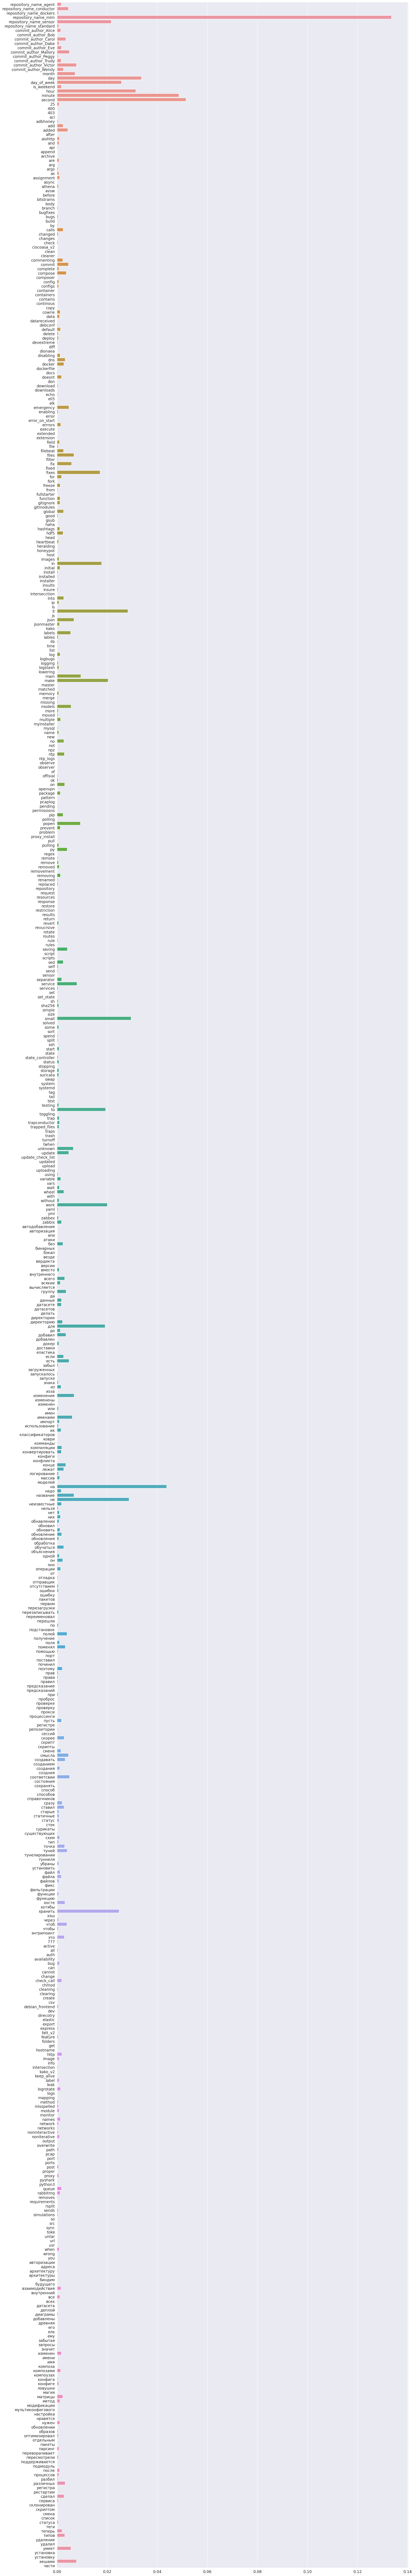

In [45]:
scores, importances = score_model_cv(RandomForestRegressor(random_state=SEED), X_train, y_train, 3)

for key, value in importances.items():
    importances[key] = np.mean(importances[key])
    
plt.figure(figsize=(20, 150))
sns.barplot(x=list(importances.values()), y=list(importances.keys()));

In [46]:
np.mean(scores)

0.22808161145397646

In [47]:
THRESHOLD = 0.1

In [48]:
Train = X_train.copy()
Test = X_test.copy()

In [57]:
for threshold in np.arange(0.05, 1., 0.05):
    imp_drop_mask = list(importances.values()) > np.quantile(list(importances.values()), threshold)
    imp_names = np.array(list(importances.keys()))[imp_drop_mask]

    vectorizer = TfidfVectorizer()
    vec_train = vectorizer.fit_transform(Train["commit_message"]).toarray()
    vec_test = vectorizer.transform(Test["commit_message"]).toarray()

    vec_train = pd.DataFrame(data=vec_train, columns=vectorizer.get_feature_names())
    vec_test = pd.DataFrame(data=vec_test, columns=vectorizer.get_feature_names())

    new_imp_names = list(set(imp_names) & set(list(Train.columns) + list(vec_train.columns)))

    x_names = list(set(imp_names) & set(Train.columns))
    vec_names = list(set(imp_names) & set(vec_train.columns))

    X_train = np.hstack([Train[x_names].to_numpy(), vec_train[vec_names]])
    X_test = np.hstack([Test[x_names].to_numpy(), vec_test[vec_names]])

    print(f"\n{threshold=}")
    fit_score_model(RandomForestRegressor(random_state=SEED), X_train, y_train, X_test, y_test)


threshold=0.05
R^2 = 0.29448406713694963
MSE = 1.812735

threshold=0.1
R^2 = 0.27439941620043784
MSE = 1.8643399999999999

threshold=0.15000000000000002
R^2 = 0.2954833373874969
MSE = 1.8101675

threshold=0.2
R^2 = 0.29798832400875686
MSE = 1.8037312500000002

threshold=0.25
R^2 = 0.28480467039649715
MSE = 1.837605

threshold=0.3
R^2 = 0.26432692775480415
MSE = 1.89022

threshold=0.35000000000000003
R^2 = 0.2807234249574311
MSE = 1.8480912500000002

threshold=0.4
R^2 = 0.29050547312089503
MSE = 1.8229575

threshold=0.45
R^2 = 0.27657115057163706
MSE = 1.8587599999999997

threshold=0.5
R^2 = 0.2708513743614691
MSE = 1.8734562500000003

threshold=0.55
R^2 = 0.27916127462904405
MSE = 1.852105

threshold=0.6000000000000001
R^2 = 0.2812332765750425
MSE = 1.84678125

threshold=0.6500000000000001
R^2 = 0.28060034054974436
MSE = 1.8484075000000004

threshold=0.7000000000000001
R^2 = 0.313740209194843
MSE = 1.7632587499999999

threshold=0.7500000000000001
R^2 = 0.3297183167112623
MSE = 1.72220

In [58]:
THRESHOLD = 0.75

imp_drop_mask = list(importances.values()) > np.quantile(list(importances.values()), THRESHOLD)
imp_names = np.array(list(importances.keys()))[imp_drop_mask]

vectorizer = TfidfVectorizer()
vec_train = vectorizer.fit_transform(Train["commit_message"]).toarray()
vec_test = vectorizer.transform(Test["commit_message"]).toarray()

vec_train = pd.DataFrame(data=vec_train, columns=vectorizer.get_feature_names())
vec_test = pd.DataFrame(data=vec_test, columns=vectorizer.get_feature_names())

new_imp_names = list(set(imp_names) & set(list(Train.columns) + list(vec_train.columns)))

x_names = list(set(imp_names) & set(Train.columns))
vec_names = list(set(imp_names) & set(vec_train.columns))

X_train = np.hstack([Train[x_names].to_numpy(), vec_train[vec_names]])
X_test = np.hstack([Test[x_names].to_numpy(), vec_test[vec_names]])

fit_score_model(CatBoostRegressor(random_state=SEED, silent=True), X_train, y_train, X_test, y_test)

R^2 = 0.3427658021969404
MSE = 1.688681116980236
